In [1]:
import pandas as pd

In [3]:
import os
import glob

def get_all_csv_files(directory):
    # Join the directory path and the pattern for .csv files
    csv_files = glob.glob(os.path.join(directory, "*.csv"))
    
    return csv_files





In [ ]:

# Example usage:
directory_path = '../data/'
csv_files = get_all_csv_files(directory_path)
count = 0
total = len(csv_files)
marker = 10
for file in csv_files:
    count += 1
    percent = 100*count/total
    if percent >= marker:
        print('percent done: %', percent)
        marker+=10
    data = pd.read_csv(file)
    data.dropna(inplace=True)
    data = data.reset_index()
    if not data.empty:
        index = data['DATE (YYYY-MM-DDTHH:MI:SSZ)'].unique()
        float_number = data['PLATFORM_CODE'].iloc[0]
        
        agg_data = {
            'float_number': []
            ,'date':[]
            ,'latitude':[]
            ,'longitude':[]
            ,'q0_psal':[]
            ,'q1_psal':[]
            ,'q2_psal':[]
            ,'q3_psal':[]
            ,'q4_psal':[]
            ,'q0_temp':[]
            ,'q1_temp':[]
            ,'q2_temp':[]
            ,'q3_temp':[]
            ,'q4_temp':[]
        }

        if 'PSAL (psu)' in data.columns and 'TEMP (degree_Celsius)' in data.columns:
            for i in index:
                subset = data[data['DATE (YYYY-MM-DDTHH:MI:SSZ)']==i]
                agg_data['float_number'].append(float_number)
                agg_data['date'].append(i)
                agg_data['latitude'].append(subset['LATITUDE (degree_north)'].iloc[0])
                agg_data['longitude'].append(subset['LONGITUDE (degree_east)'].iloc[0])
                q0 = min(subset['PRES (decibar)'])
                q1 = min(subset['PRES (decibar)'], key=lambda x:abs(x-500))
                q2 = min(subset['PRES (decibar)'], key=lambda x:abs(x-1000))
                q3 = min(subset['PRES (decibar)'], key=lambda x:abs(x-1500))
                q4 = max(subset['PRES (decibar)'])
                agg_data['q0_psal'].append(subset[subset['PRES (decibar)']==q0]['PSAL (psu)'].iloc[0])
                agg_data['q1_psal'].append(subset[subset['PRES (decibar)']==q1]['PSAL (psu)'].iloc[0])
                agg_data['q2_psal'].append(subset[subset['PRES (decibar)']==q2]['PSAL (psu)'].iloc[0])
                agg_data['q3_psal'].append(subset[subset['PRES (decibar)']==q3]['PSAL (psu)'].iloc[0])
                agg_data['q4_psal'].append(subset[subset['PRES (decibar)']==q4]['PSAL (psu)'].iloc[0])
                agg_data['q0_temp'].append(subset[subset['PRES (decibar)']==q0]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q1_temp'].append(subset[subset['PRES (decibar)']==q1]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q2_temp'].append(subset[subset['PRES (decibar)']==q2]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q3_temp'].append(subset[subset['PRES (decibar)']==q3]['TEMP (degree_Celsius)'].iloc[0])
                agg_data['q4_temp'].append(subset[subset['PRES (decibar)']==q4]['TEMP (degree_Celsius)'].iloc[0])
            agg_data = pd.DataFrame(agg_data)
            agg_data['date'] = pd.to_datetime(agg_data['date'])
            agg_data['date'] = agg_data['date'].dt.strftime('%Y-%m-%d') 
            
            all_data = pd.concat([agg_data, all_data])
            all_data.to_csv('all_ocean_data.csv', index=False)




In [2]:
import pandas as pd
all_data = pd.read_csv('all_ocean_data.csv')

In [3]:
pd.set_option('display.min_rows', 70)
pd.set_option('display.max_columns', None)

In [4]:
sorted_data = all_data.sort_values(['date','float_number'], ascending=[True, True])

In [5]:
undup = sorted_data.drop_duplicates()
undup.shape

(681519, 14)

In [ ]:
for date in undup['date'].unique():

    print(undup[undup['date']==date][['date', 'latitude','longitude']])

In [23]:
import datetime as dt
undup['date'] = pd.to_datetime(undup['date'])
undup = undup[undup['date'].dt.year==2006]

C:\Users\Jon\AppData\Local\Temp\ipykernel_39148\3366570401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undup['date'] = pd.to_datetime(undup['date'])


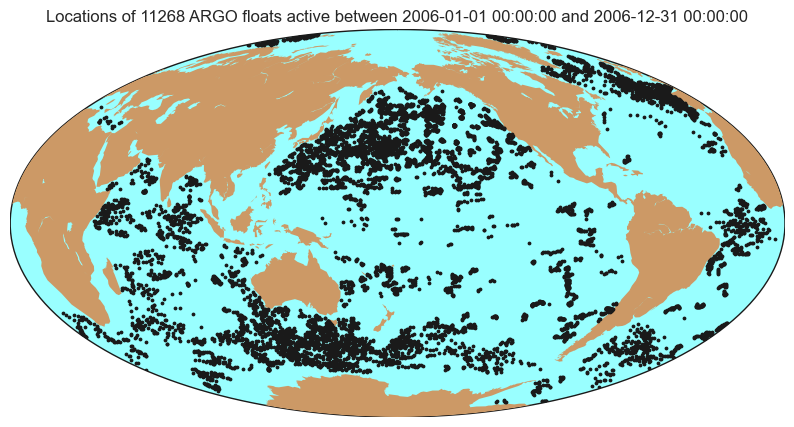

In [24]:
from netCDF4 import Dataset, num2date
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import os
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
# data downloaded from the form at
# http://coastwatch.pfeg.noaa.gov/erddap/tabledap/apdrcArgoAll.html

lats = undup['latitude']
lons = undup['longitude']
time = undup['date']  # seconds since epoch
times = time
t1 = times.min(); t2 = times.max()
date1 = t1
date2 = t2

# draw map with markers for float locations
m = Basemap(projection='hammer',lon_0=180)
x, y = m(lons,lats)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.scatter(x,y,3,marker='o',color='k')
plt.title('Locations of %s ARGO floats active between %s and %s' %\
        (len(lats),date1,date2),fontsize=12)
plt.show()

## Making data for animated map

In [70]:
import pandas as pd
import numpy as np

def generate_interpolated_rows(df):
    # Sort the dataframe by 'id' and 'date' for each id
    df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is a datetime object
    df = df.sort_values(by=['float_number', 'date'])

    new_rows = []

    for idx in range(len(df) - 1):
        current_row = df.iloc[idx]
        next_row = df.iloc[idx + 1]

        # Check if it's the same 'id'
        if current_row['float_number'] == next_row['float_number']:
            # Calculate the number of days between the two dates
            days_diff = (next_row['date'] - current_row['date']).days
            
            if days_diff > 1 and days_diff<31:
                # Generate evenly spaced latitudes, longitudes, and dates
                latitudes = np.linspace(current_row['latitude'], next_row['latitude'], round((days_diff + 1)/2))
                longitudes = np.linspace(current_row['longitude'], next_row['longitude'], round((days_diff + 1)/2))
                dates = pd.date_range(current_row['date'], next_row['date'], periods=round((days_diff + 1)/2))
                
                # Add the interpolated rows (excluding the first one because it's already in df)
                for i in range(1, round(days_diff/2)):
                    new_row = {
                        'float_number': current_row['float_number'],
                        'latitude': latitudes[i],
                        'longitude': longitudes[i],
                        'date': dates[i]
                    }
                    new_rows.append(new_row)

    # Convert the new_rows list into a DataFrame and append to the original DataFrame
    new_rows_df = pd.DataFrame(new_rows)
    df = pd.concat([df, new_rows_df]).sort_values(by=['float_number', 'date']).reset_index(drop=True)
    
    return df



In [71]:
all_ocean = pd.read_csv('all_ocean_data.csv')[['float_number','date','longitude','latitude']]

In [72]:
id_index = all_ocean['float_number'].unique()

In [73]:
all_df = generate_interpolated_rows(all_ocean[all_ocean['float_number']==id_index[0]])
all_df.to_csv('data_for_map.csv', index=False)

In [74]:
all_df = pd.read_csv('data_for_map.csv')
all_df

,float_number,date,longitude,latitude


In [11]:
import warnings
warnings.simplefilter('ignore')

In [75]:
import warnings
# Helpful for keeping the output clear
warnings.simplefilter('ignore')
all_df = pd.read_csv('data_for_map.csv')
count = 0
total = len(id_index)
marker = 0


for id in id_index:
    count += 1
    percent = 100*count/total
    if percent >= marker:
        print('percent done: %', percent)
        marker+=10
    new_df = generate_interpolated_rows(all_ocean[all_ocean['float_number']==id])
    all_df = pd.concat([new_df, all_df])
    # all_df.to_csv('data_for_map.csv', index=False) This significantly slowed down the process by like a factor of 1000
    # And I think it was not correctly saving it either
    


percent done: % 0.008768853034023149
percent done: % 10.005261311820414
percent done: % 20.001753770606804
percent done: % 30.00701508242722
percent done: % 40.00350754121361
percent done: % 50.0
percent done: % 60.00526131182041
percent done: % 70.00175377060681
percent done: % 80.00701508242722
percent done: % 90.00350754121361
percent done: % 100.0


In [80]:
all_df.to_csv('data_for_map.csv', index=False)

In [58]:
len(id_index)

9534

In [61]:
data_map = pd.read_csv('data_for_map.csv')

In [62]:
new_index = data_map['float_number'].unique()

In [63]:
len(new_index)

11404

In [55]:
id_index = [item for item in id_index if item not in new_index]

## Make data for lstm

In [78]:
id_index = all_ocean['float_number'].unique()

In [21]:
import numpy as np
all_ocean = pd.read_csv('all_ocean_data.csv')
all_ocean['date'] = pd.to_datetime(all_ocean['date'])  # Ensure 'date' is a datetime object
all_ocean = all_ocean.sort_values(by=['float_number', 'date'], ascending=True)
id_index = all_ocean['float_number'].unique()
last_index = id_index[0]
recent = all_ocean[all_ocean['float_number']==last_index]
recent['distance'] = 0
lstm_df = recent

count = 0
total = len(id_index)
marker = 0


for _ in range(len(id_index)):
    count += 1
    percent = 100*count/total
    if percent >= marker:
        print('percent done: %', percent)
        marker+=10
    last_lat, last_long = recent['latitude'].iloc[-1], recent['longitude'].iloc[-1]
    id_index = [item for item in id_index if item != last_index]
    best = np.inf
    for id in id_index:
        next_lat, next_long = all_ocean[all_ocean['float_number']==id]['latitude'].iloc[0], all_ocean[all_ocean['float_number']==id]['longitude'].iloc[0]
        distance = (((next_lat-last_lat)**2) + ((next_long - last_long)**2))**0.5
        if distance < best:
            last_index = id
            best = distance
    recent = all_ocean[all_ocean['float_number']==last_index] 
    recent['distance'] = best
    lstm_df = pd.concat([lstm_df, recent])




percent done: % 0.008768853034023149
percent done: % 10.005261311820414
percent done: % 20.001753770606804
percent done: % 30.00701508242722
percent done: % 40.00350754121361
percent done: % 50.0
percent done: % 60.00526131182041
percent done: % 70.00175377060681
percent done: % 80.00701508242722
percent done: % 90.00350754121361
percent done: % 100.0


In [22]:
lstm_df.to_csv('lstm_data.csv', index=False)

## LSTM Model

In [23]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [24]:
df = pd.read_csv('lstm_data.csv')

In [25]:
df

,Unnamed: 0,float_number,date,latitude,longitude,q0_psal,q1_psal,q2_psal,q3_psal,q4_psal,q0_temp,q1_temp,q2_temp,q3_temp,q4_temp,distance
0,527182,29034,2000-11-09,29.541,144.013,34.637,34.545,34.216,34.472,34.585,26.977,14.051,4.273,2.675,2.040,0.0
1,527183,29034,2000-12-09,28.980,143.237,34.718,34.475,34.270,34.473,34.583,24.441,13.197,4.491,2.730,2.038,0.0
2,527184,29034,2000-12-19,28.880,143.215,34.658,34.522,34.257,34.485,34.591,23.377,13.794,4.709,2.609,2.005,0.0
3,527185,29034,2000-12-29,28.709,143.096,34.685,34.502,34.293,34.487,34.590,22.036,13.525,4.520,2.637,2.029,0.0
4,527186,29034,2001-01-08,28.504,143.012,34.762,34.447,34.296,34.493,34.596,21.855,12.802,4.298,2.591,1.986,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681535,420272,4900946,2013-06-09,45.865,-175.566,33.165,34.102,34.367,34.501,34.578,8.213,3.900,2.868,2.289,1.942,inf
681536,420273,4900946,2013-07-19,46.202,-175.465,32.923,34.073,34.375,34.498,34.573,11.690,3.750,2.887,2.312,1.961,inf
681537,420274,4900946,2013-08-08,46.298,-175.172,32.876,34.086,34.367,34.499,34.575,12.810,3.766,2.874,2.306,1.956,inf
681538,420275,4900946,2013-09-17,46.102,-173.380,32.888,34.059,34.369,34.496,34.578,12.274,3.831,2.914,2.320,1.946,inf


<Axes: >

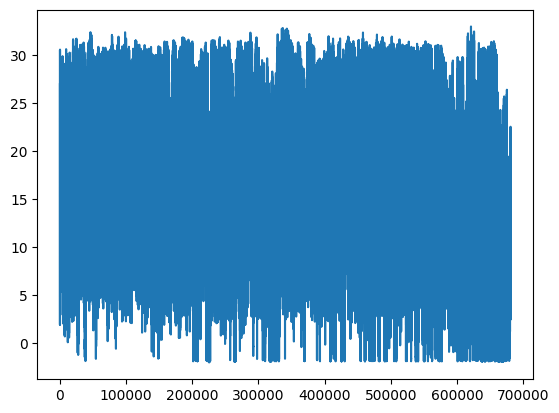

In [26]:
temp = df['q0_temp']
temp.plot()

<Axes: >

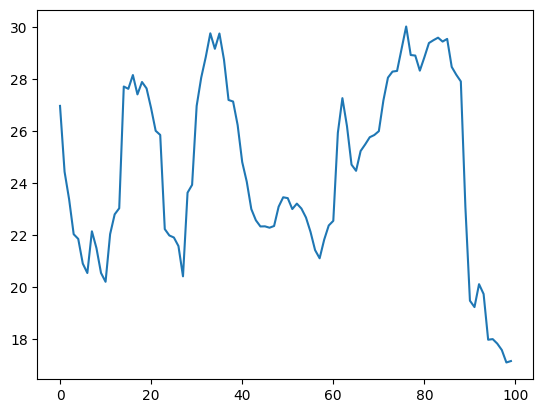

In [28]:
temp[:100].plot()

In [29]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [30]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((681535, 5, 1), (681535,))

In [31]:
X1

array([[[26.977],
        [24.441],
        [23.377],
        [22.036],
        [21.855]],

       [[24.441],
        [23.377],
        [22.036],
        [21.855],
        [20.904]],

       [[23.377],
        [22.036],
        [21.855],
        [20.904],
        [20.542]],

       ...,

       [[ 5.773],
        [ 5.948],
        [ 6.765],
        [ 8.213],
        [11.69 ]],

       [[ 5.948],
        [ 6.765],
        [ 8.213],
        [11.69 ],
        [12.81 ]],

       [[ 6.765],
        [ 8.213],
        [11.69 ],
        [12.81 ],
        [12.274]]])

In [36]:
train_size = round(0.6*(len(X1)))
val_size = round(0.3*(len(X1)))

X_train1, y_train1 = X1[:train_size], y1[:train_size]
X_val1, y_val1 = X1[train_size:train_size+val_size], y1[train_size:train_size+val_size]
X_test1, y_test1 = X1[train_size+val_size:], y1[train_size+val_size:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((408921, 5, 1), (408921,), (204460, 5, 1), (204460,), (68154, 5, 1), (68154,))

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [39]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
12761/12779 [============================>.] - ETA: 0s - loss: 32.3544 - root_mean_squared_error: 5.6881INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12779/12779 [==============================] - 29s 2ms/step - loss: 32.3126 - root_mean_squared_error: 5.6844 - val_loss: 3.0823 - val_root_mean_squared_error: 1.7557
Epoch 2/10
12767/12779 [============================>.] - ETA: 0s - loss: 2.3315 - root_mean_squared_error: 1.5269INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12779/12779 [==============================] - 27s 2ms/step - loss: 2.3311 - root_mean_squared_error: 1.5268 - val_loss: 3.0548 - val_root_mean_squared_error: 1.7478
Epoch 3/10
12760/12779 [============================>.] - ETA: 0s - loss: 2.3051 - root_mean_squared_error: 1.5183INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12779/12779 [==============================] - 25s 2ms/step - loss: 2.3061 - root_mean_squared_error: 1.5186 - val_loss: 3.0323 - val_root_mean_squared_error: 1.7414
Epoch 4/10
12779/12779 [==============================] - 24s 2ms/step - loss: 2.2919 - root_mean_squared_error: 1.5139 - val_loss: 3.0607 - val_root_mean_squared_error: 1.7495
Epoch 5/10
12761/12779 [============================>.] - ETA: 0s - loss: 2.2825 - root_mean_squared_error: 1.5108INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12779/12779 [==============================] - 27s 2ms/step - loss: 2.2817 - root_mean_squared_error: 1.5105 - val_loss: 3.0279 - val_root_mean_squared_error: 1.7401
Epoch 6/10
12769/12779 [============================>.] - ETA: 0s - loss: 2.2728 - root_mean_squared_error: 1.5076INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12779/12779 [==============================] - 27s 2ms/step - loss: 2.2741 - root_mean_squared_error: 1.5080 - val_loss: 3.0163 - val_root_mean_squared_error: 1.7367
Epoch 7/10
12749/12779 [============================>.] - ETA: 0s - loss: 2.2680 - root_mean_squared_error: 1.5060INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12779/12779 [==============================] - 28s 2ms/step - loss: 2.2681 - root_mean_squared_error: 1.5060 - val_loss: 3.0050 - val_root_mean_squared_error: 1.7335
Epoch 8/10
12775/12779 [============================>.] - ETA: 0s - loss: 2.2616 - root_mean_squared_error: 1.5039INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12779/12779 [==============================] - 28s 2ms/step - loss: 2.2613 - root_mean_squared_error: 1.5038 - val_loss: 2.9909 - val_root_mean_squared_error: 1.7294
Epoch 9/10
12779/12779 [==============================] - 26s 2ms/step - loss: 2.2568 - root_mean_squared_error: 1.5023 - val_loss: 3.0078 - val_root_mean_squared_error: 1.7343
Epoch 10/10
12779/12779 [==============================] - 27s 2ms/step - loss: 2.2519 - root_mean_squared_error: 1.5006 - val_loss: 3.0052 - val_root_mean_squared_error: 1.7336


In [40]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [41]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

12779/12779 [==============================] - 11s 832us/step


,Train Predictions,Actuals
0,21.581003,20.904
1,20.650097,20.542
2,20.327770,22.148
3,22.411264,21.500
4,21.586809,20.544
...,...,...
408916,0.390581,0.692
408917,0.643924,0.920
408918,0.872260,0.969
408919,0.855173,1.040


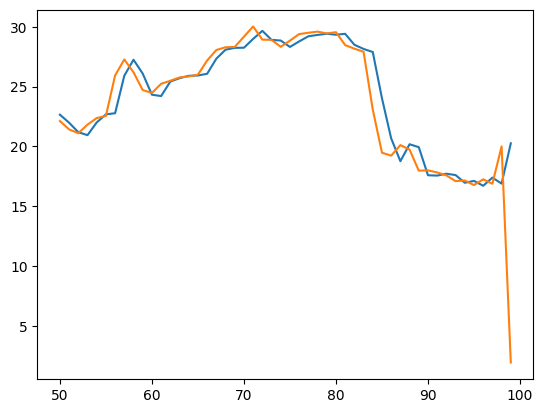

In [42]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [43]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

2130/2130 [==============================] - 2s 936us/step


,Test Predictions,Actuals
0,8.309370,11.238
1,12.076814,11.790
2,11.526076,13.346
3,13.365479,14.935
4,15.095508,15.643
...,...,...
68149,7.011014,8.213
68150,8.962414,11.690
68151,12.434262,12.810
68152,12.792117,12.274


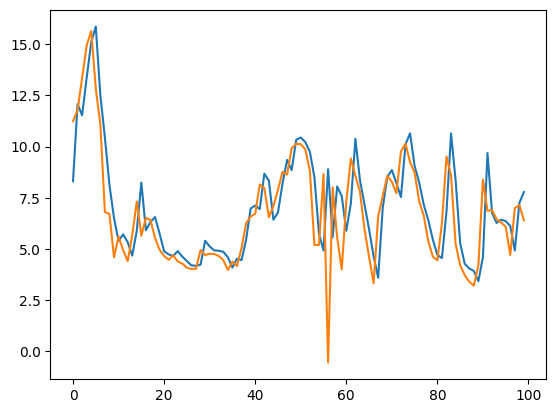

In [47]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])
